<a href="https://colab.research.google.com/github/Facumor4/Facundo-Mora-/blob/main/demand_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
atomicd_retail_store_inventory_and_demand_forecasting_path = kagglehub.dataset_download('atomicd/retail-store-inventory-and-demand-forecasting')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-store-inventory-and-demand-forecasting/sales_data.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error


In [24]:
df = pd.read_csv('/kaggle/input/retail-store-inventory-and-demand-forecasting/sales_data.csv')
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [5]:
df.describe()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,301.062842,88.827316,89.090645,67.726028,9.087039,0.328947,69.454029,0.200000,104.317158
std,226.510161,43.994525,162.404627,39.377899,7.475781,0.469834,40.943818,0.400003,46.964801
min,0.000000,0.000000,0.000000,4.740000,0.000000,0.000000,4.290000,0.000000,4.000000
25%,136.000000,58.000000,0.000000,31.997500,5.000000,0.000000,32.620000,0.000000,71.000000
50%,227.000000,84.000000,0.000000,64.500000,10.000000,0.000000,65.700000,0.000000,100.000000
75%,408.000000,114.000000,121.000000,95.830000,10.000000,1.000000,97.932500,0.000000,133.000000
max,2267.000000,426.000000,1616.000000,228.030000,25.000000,1.000000,261.220000,1.000000,430.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

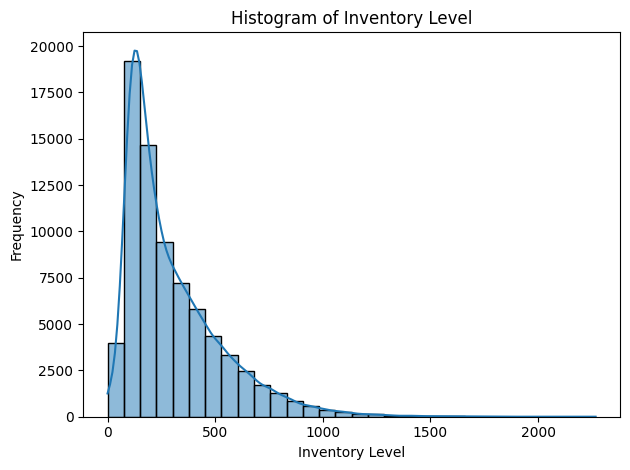

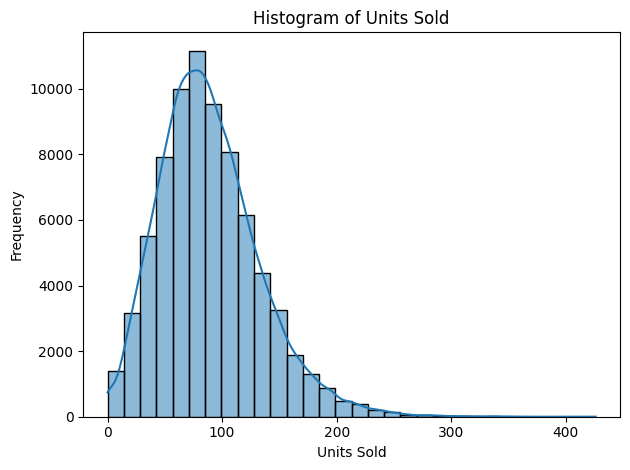

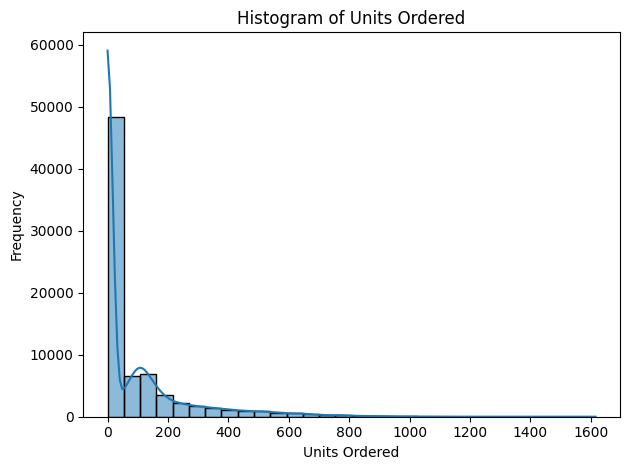

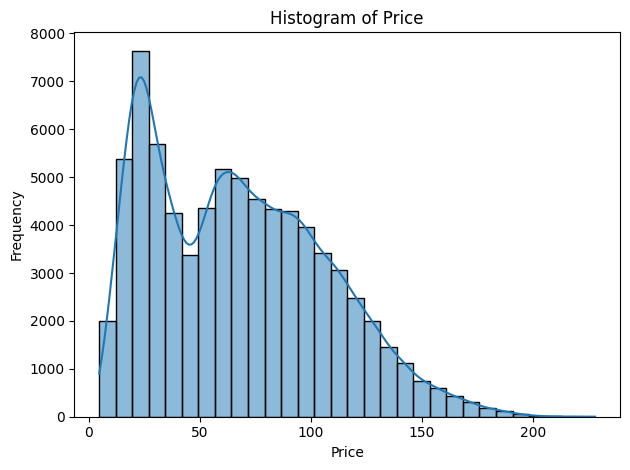

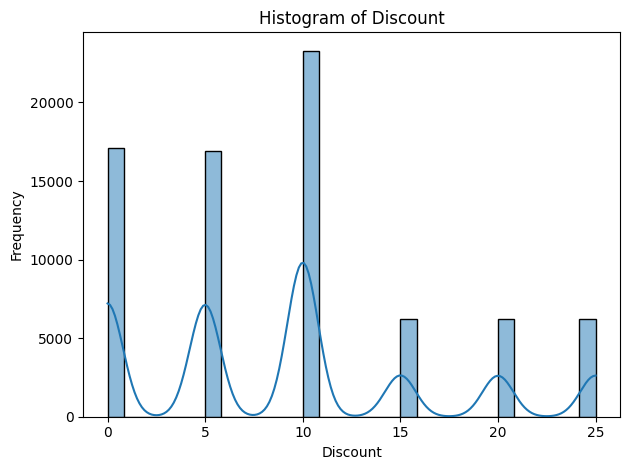

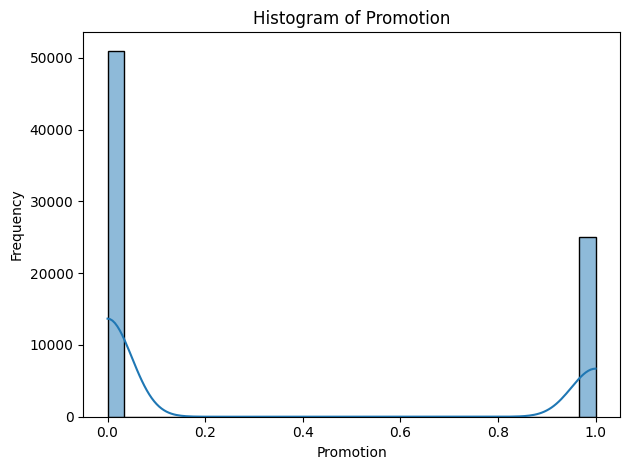

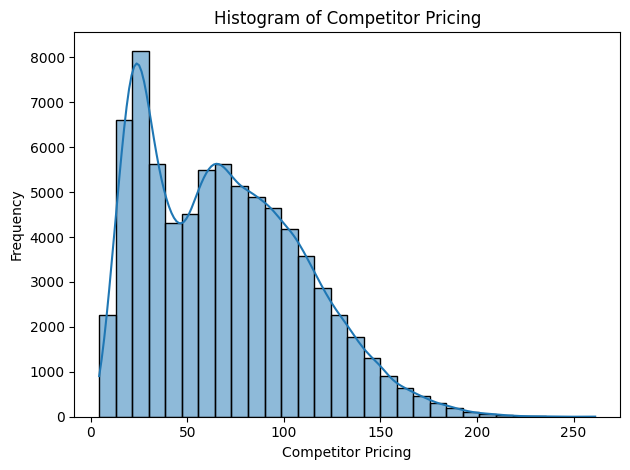

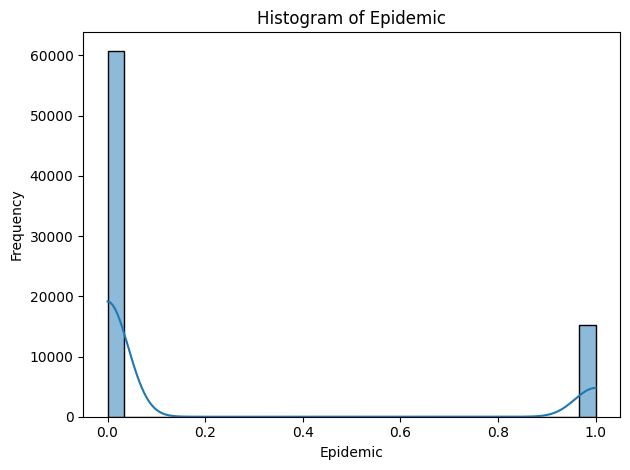

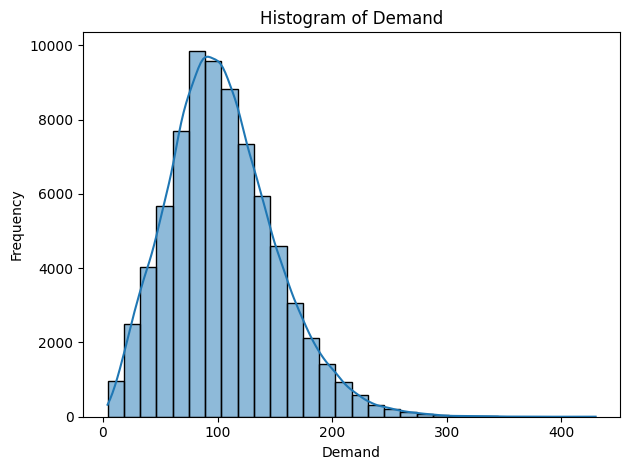

In [8]:
numeric_cols = ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'Demand']
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [27]:
df.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
75995,2024-01-30,S005,P0016,Toys,North,233,63,0,29.80,5,Snowy,0,32.23,Winter,0,64
75996,2024-01-30,S005,P0017,Toys,North,137,115,141,42.92,5,Snowy,0,40.73,Winter,0,137
75997,2024-01-30,S005,P0018,Clothing,North,197,44,0,17.81,10,Snowy,0,19.41,Winter,0,68
75998,2024-01-30,S005,P0019,Furniture,North,125,58,0,151.72,0,Snowy,0,143.71,Winter,0,84
75999,2024-01-30,S005,P0020,Toys,North,126,63,59,25.78,10,Snowy,0,29.32,Winter,0,73


In [33]:
import pandas as pd

# Asegurate de que la columna 'Date' sea del tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ahora podés restar las fechas directamente
dias = (df['Date'].iloc[75999] - df['Date'].iloc[0]).days

print(dias)
print()

759


In [38]:
dias_diferencia = (df['Date'][75999] - df['Date'][0]).days
print(dias_diferencia)

759


In [40]:
df['Units Sold'].mean()

np.float64(88.82731578947369)


📊 Análisis de normalidad para: Inventory Level
  Shapiro-Wilk: stat=0.8598, p=0.0000
  Kolmogorov-Smirnov: stat=0.1324, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


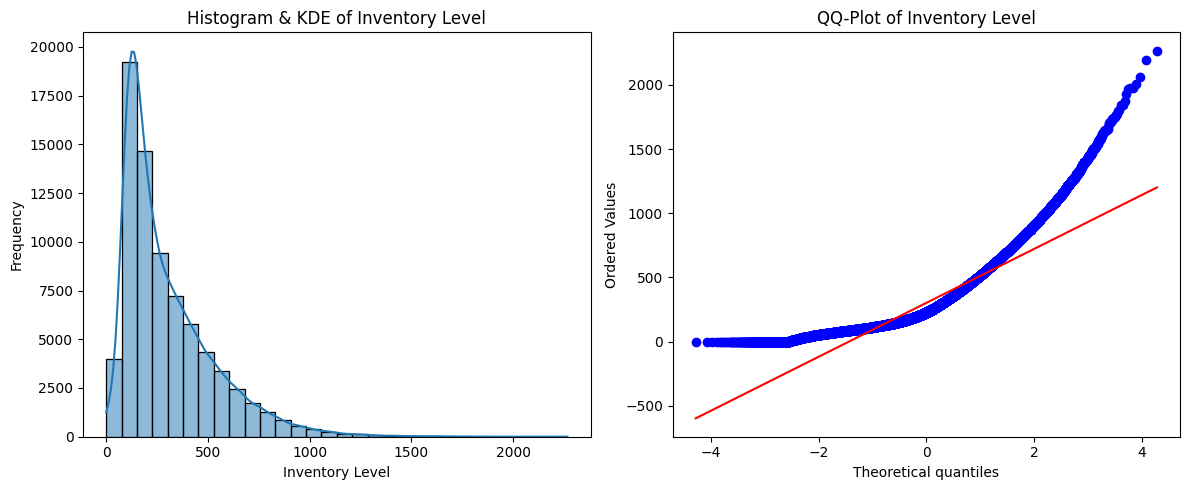


📊 Análisis de normalidad para: Units Sold
  Shapiro-Wilk: stat=0.9685, p=0.0000
  Kolmogorov-Smirnov: stat=0.0525, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


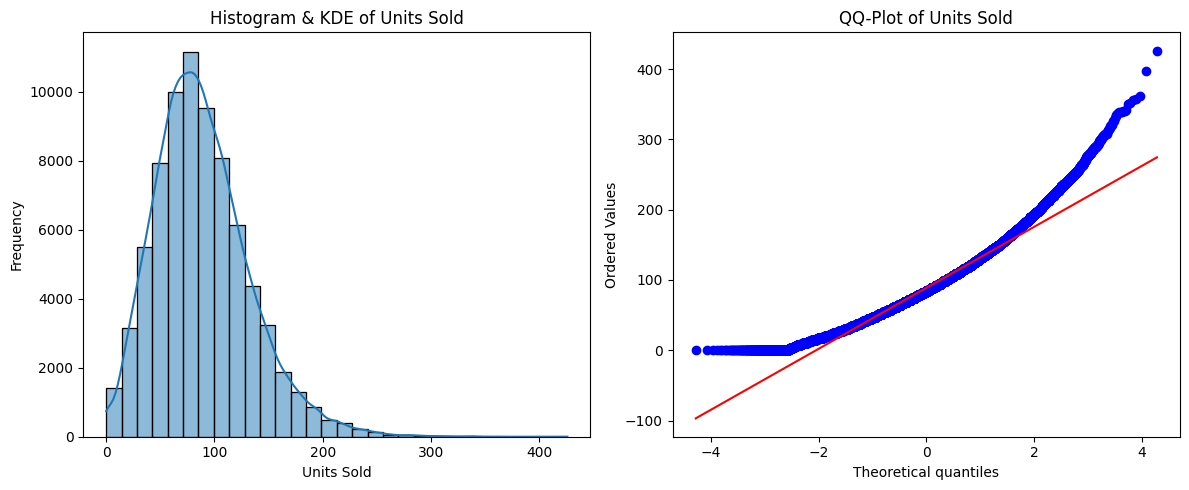


📊 Análisis de normalidad para: Units Ordered
  Shapiro-Wilk: stat=0.6209, p=0.0000
  Kolmogorov-Smirnov: stat=0.3282, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


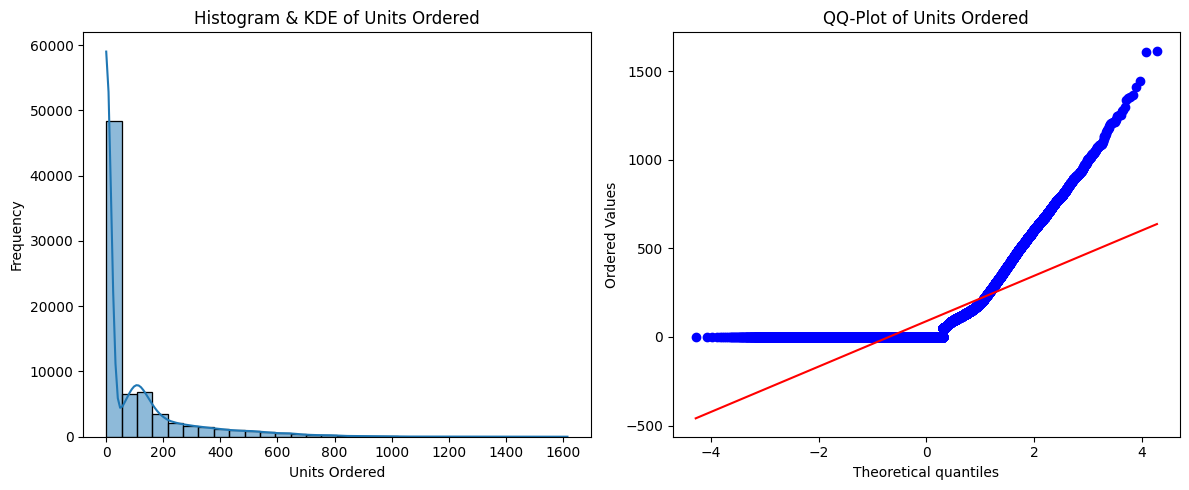


📊 Análisis de normalidad para: Price
  Shapiro-Wilk: stat=0.9599, p=0.0000
  Kolmogorov-Smirnov: stat=0.0766, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


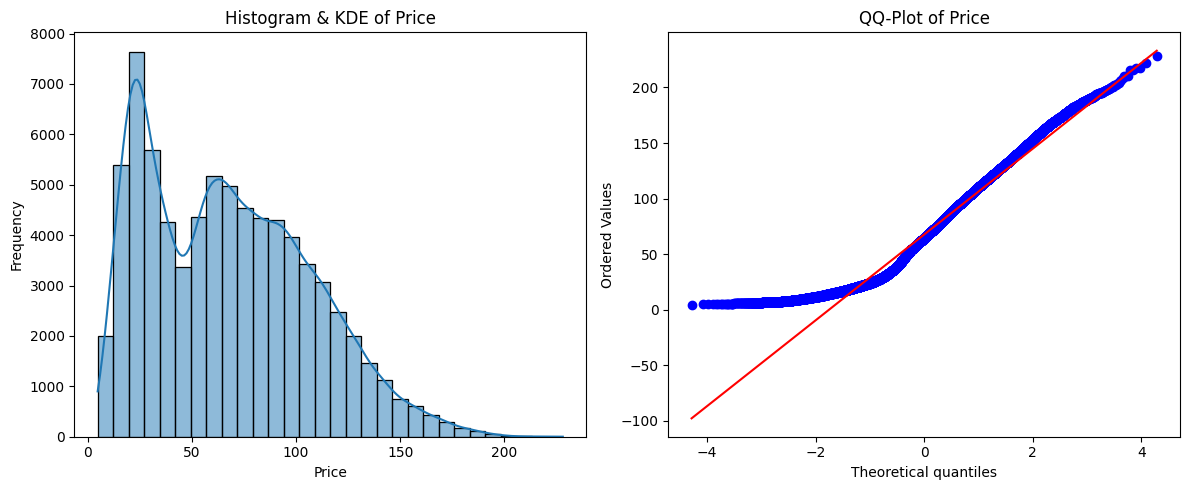


📊 Análisis de normalidad para: Discount
  Shapiro-Wilk: stat=0.8872, p=0.0000
  Kolmogorov-Smirnov: stat=0.2059, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


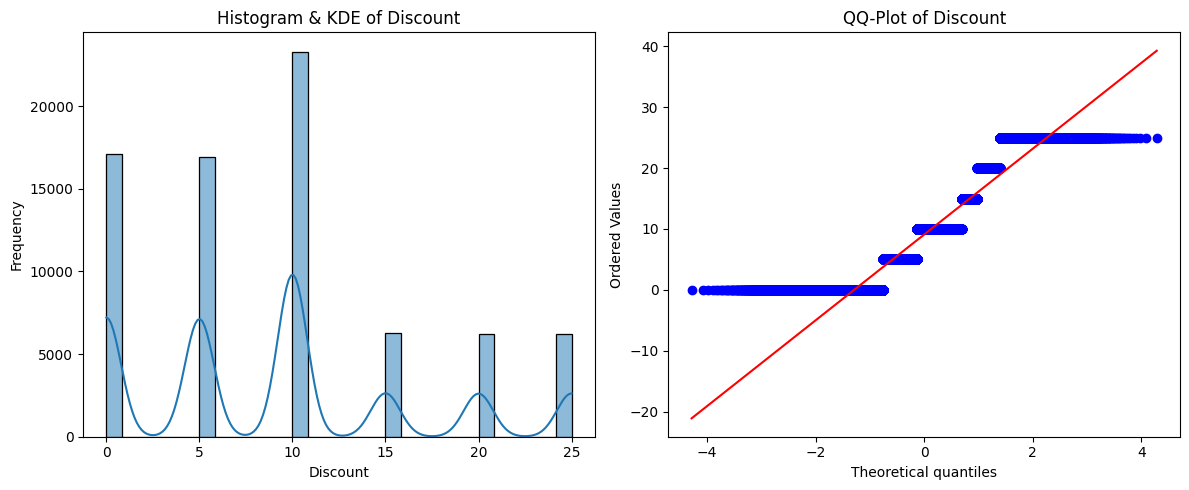


📊 Análisis de normalidad para: Promotion
  Shapiro-Wilk: stat=0.5926, p=0.0000
  Kolmogorov-Smirnov: stat=0.4291, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


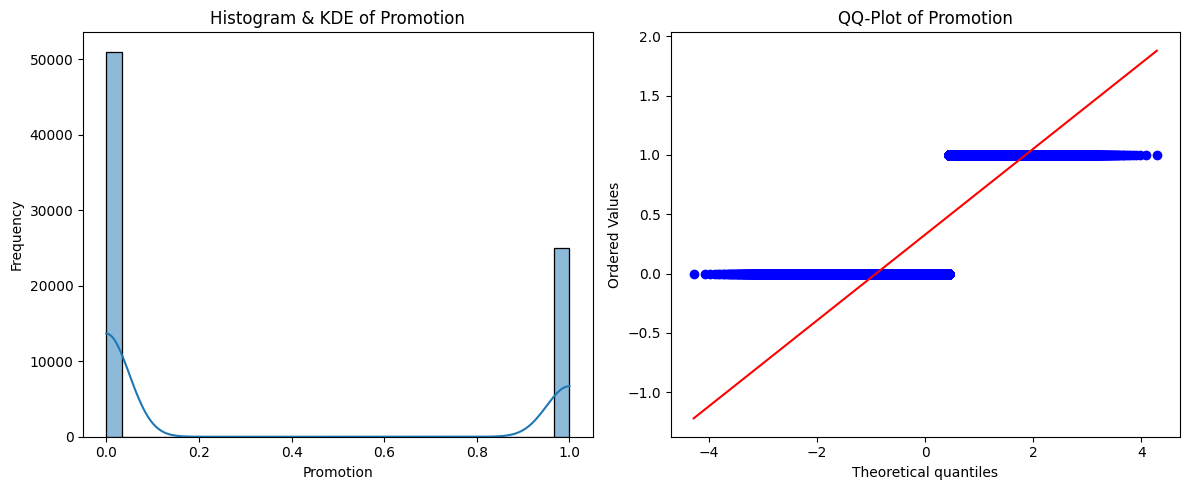


📊 Análisis de normalidad para: Competitor Pricing
  Shapiro-Wilk: stat=0.9582, p=0.0000
  Kolmogorov-Smirnov: stat=0.0732, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


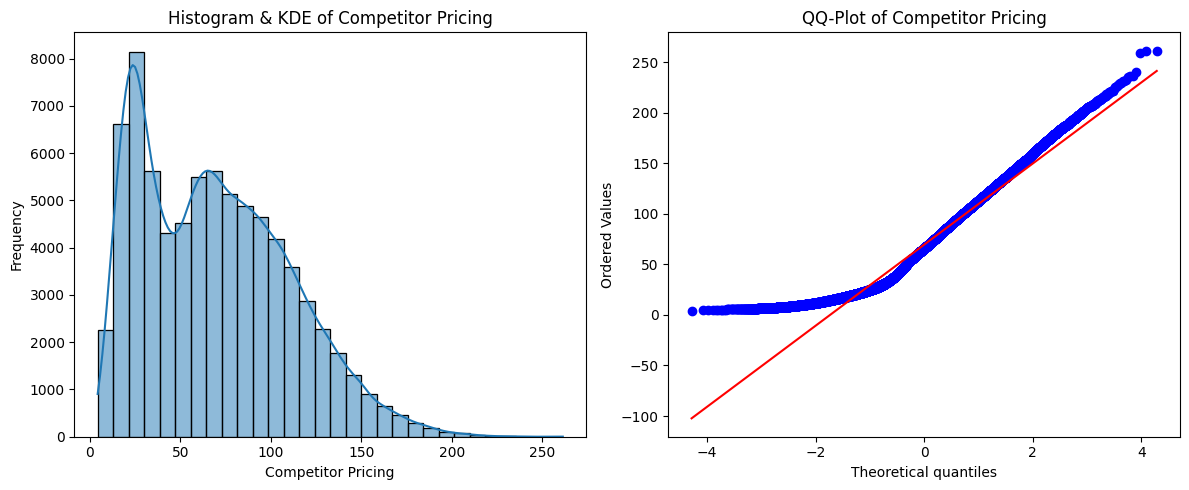


📊 Análisis de normalidad para: Epidemic
  Shapiro-Wilk: stat=0.4899, p=0.0000
  Kolmogorov-Smirnov: stat=0.4915, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


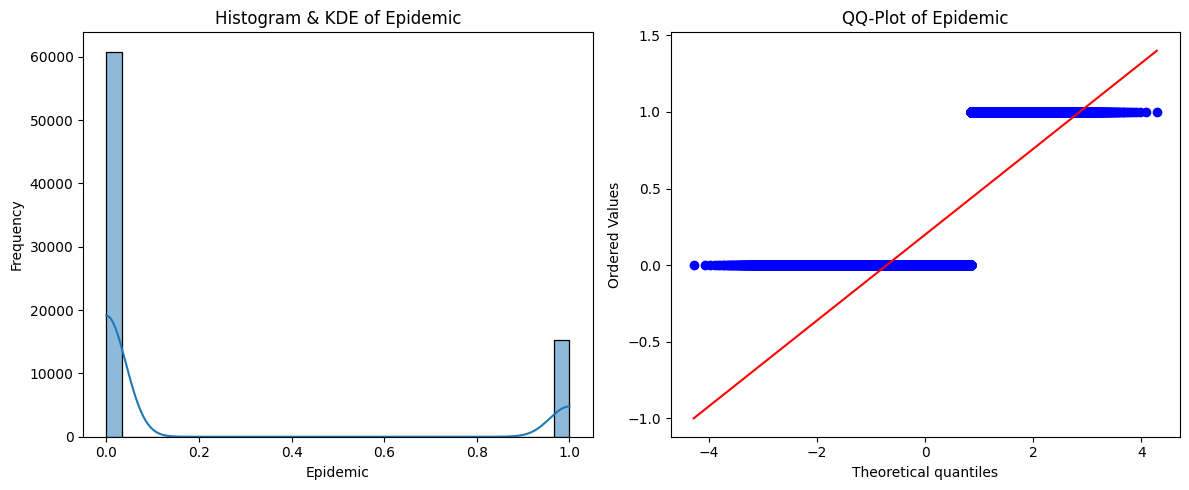


📊 Análisis de normalidad para: Demand
  Shapiro-Wilk: stat=0.9796, p=0.0000
  Kolmogorov-Smirnov: stat=0.0427, p=0.0000
  ❌ No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76000.
  res = hypotest_fun_out(*samples, **kwds)


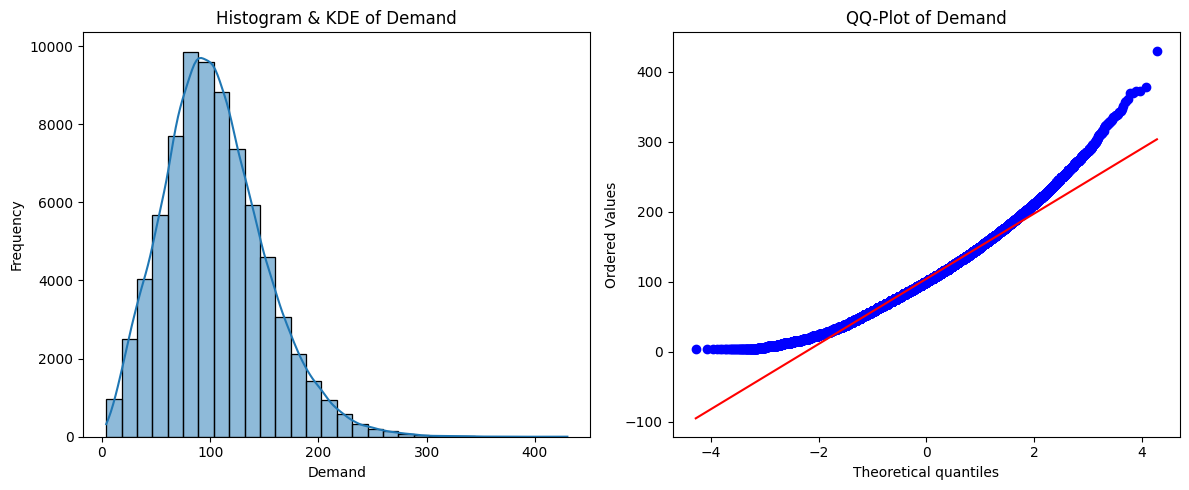

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Columnas numéricas que quieres analizar
numeric_cols = ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'Demand']

def check_normality(df, columns):
    for col in columns:
        data = df[col].dropna()  # Elimina NaNs
        print(f"\n📊 Análisis de normalidad para: {col}")

        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = stats.shapiro(data)
        print(f"  Shapiro-Wilk: stat={shapiro_stat:.4f}, p={shapiro_p:.4f}")

        # Kolmogorov-Smirnov Test (comparando con distribución normal estándar)
        # Normalizamos los datos antes
        standardized_data = (data - data.mean()) / data.std()
        ks_stat, ks_p = stats.kstest(standardized_data, 'norm')
        print(f"  Kolmogorov-Smirnov: stat={ks_stat:.4f}, p={ks_p:.4f}")

        # Interpretación
        if shapiro_p > 0.05 and ks_p > 0.05:
            print("  ✅ Podría ser una distribución normal (no se rechaza H0)")
        else:
            print("  ❌ No parece una distribución normal (se rechaza H0)")

        # Histograma + KDE
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data, kde=True, bins=30)
        plt.title(f'Histogram & KDE of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # QQ-Plot
        plt.subplot(1, 2, 2)
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'QQ-Plot of {col}')

        plt.tight_layout()
        plt.show()

# Ejemplo de uso:
check_normality(df, numeric_cols)


In [9]:
df.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Price,0
Discount,0


In [10]:
def decompose_date(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter']= df['Date'].dt.quarter
    df['Day_of_Week']=df['Date'].dt.dayofweek
    df['Is_Weekend'] = df['Day_of_Week'] >= 5

    return df

In [11]:
df = decompose_date(df)

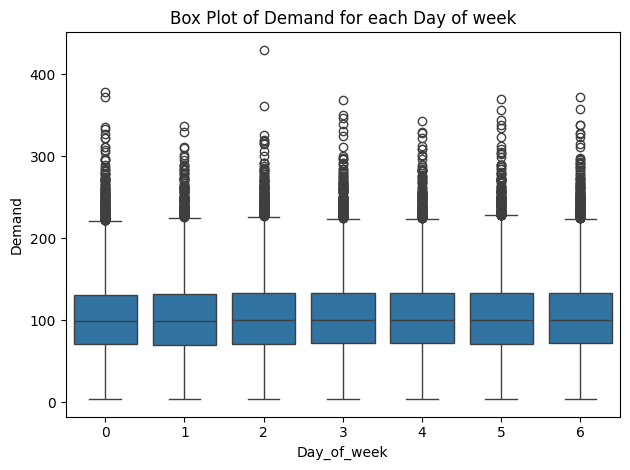

In [12]:
plt.figure()
sns.boxplot(x='Day_of_Week', y='Demand', data=df)
plt.title('Box Plot of Demand for each Day of week')
plt.xlabel('Day_of_week')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

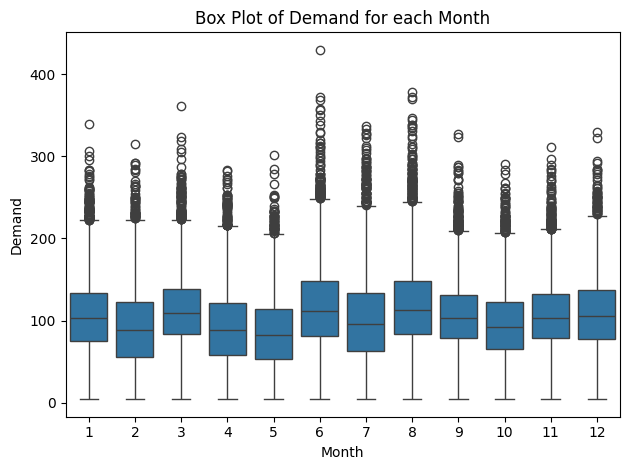

In [13]:
plt.figure()
sns.boxplot(x='Month', y='Demand', data=df)
plt.title('Box Plot of Demand for each Month')
plt.xlabel('Month')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

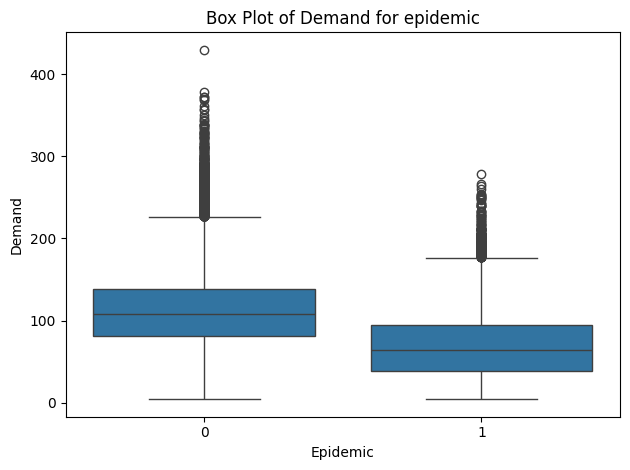

In [14]:
plt.figure()
sns.boxplot(x='Epidemic', y='Demand', data=df)
plt.title('Box Plot of Demand for epidemic')
plt.xlabel('Epidemic')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

In [15]:
import holidays

us_holidays = holidays.US(years=[2022,2023,2024])  # You can pass multiple years

# Check if each date is a holiday
df['Is_Holiday'] = df['Date'].isin(us_holidays)


<ipython-input-15-d78e40568be8>:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Is_Holiday'] = df['Date'].isin(us_holidays)


In [16]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Competitor Pricing,Seasonality,Epidemic,Demand,Year,Month,Quarter,Day_of_Week,Is_Weekend,Is_Holiday
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,...,85.73,Winter,0,115,2022,1,1,5,True,True
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,...,92.02,Winter,0,229,2022,1,1,5,True,True
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,...,60.08,Winter,0,157,2022,1,1,5,True,True
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,...,85.19,Winter,0,52,2022,1,1,5,True,True
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,...,51.63,Winter,0,59,2022,1,1,5,True,True


In [17]:

df = df.drop(columns=['Date','Product ID','Store ID'])
df =pd.get_dummies(df)
df.head()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand,Year,...,Region_South,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,195,102,252,72.72,5,0,85.73,0,115,2022,...,False,False,False,False,True,False,False,False,False,True
1,117,117,249,80.16,15,1,92.02,0,229,2022,...,False,False,False,False,True,False,False,False,False,True
2,247,114,612,62.94,10,1,60.08,0,157,2022,...,False,False,False,False,True,False,False,False,False,True
3,139,45,102,87.63,10,0,85.19,0,52,2022,...,False,False,False,False,True,False,False,False,False,True
4,152,65,271,54.41,0,0,51.63,0,59,2022,...,False,False,False,False,True,False,False,False,False,True


In [18]:
for lag in [1, 2, 5,7]:
    df[f'lag_{lag}'] = df['Demand'].shift(lag)

# Rolling averages (with shift to prevent leakage)
for window in [3, 7, 14]:
    df[f'roll_mean_{window}'] = df['Demand'].shift(1).rolling(window=window).mean()
    df[f'roll_std_{window}'] = df['Demand'].shift(1).rolling(window=window).std()

In [19]:
df.dropna(inplace=True)

y = df['Demand']
X = df.drop(columns=['Demand'])


In [20]:
X_train_lag,X_test_lag, y_train, y_test = train_test_split(X,y,random_state=42)

In [21]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor(device='cuda')


In [22]:
model.fit(X_train_lag, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:39:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:39:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred = model.predict(X_test_lag)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R² score on test data: {r2_score(y_test, y_pred)}")


MAE: 12.335569381713867
R² score on test data: 0.8759850263595581
